In [4]:
%load_ext watermark
%watermark -m -v -p numpy,tensorflow,matplotlib,pandas

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
CPython 3.6.2
IPython 6.0.0

numpy 1.12.1
tensorflow 1.1.0
matplotlib 2.0.0
pandas 0.20.3

compiler   : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [1]:
import numpy as np 
import tensorflow as tf 
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from scipy.special import expit

In [2]:
!wc  '/tensorflow/data.csv'

 199  200 8203 /tensorflow/data.csv


In [3]:
df = pd.read_csv('/tensorflow/data.csv',names='x1 x2 y'.split(' '))

In [7]:
df.head()

,x1,x2,y
0,0.344499,1.935181,0
1,-0.192481,0.942664,1
2,0.582722,-0.880124,1
3,0.151550,-1.011649,1
4,0.545083,-1.713502,0


In [25]:
X = df[['x1','x2']].values
Y = df[['y']].values

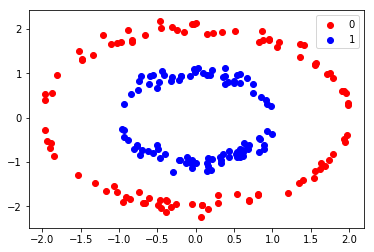

In [36]:
## 图像观察
X1 = df[df.y == 1]
X0 = df[df.y == 0]
#知道index的情况下用ix取colomn
plt.scatter(X0.ix[:,0].values,X0.ix[:,1].values,label=0,color='red')
plt.scatter(X1.ix[:,0].values,X1.ix[:,1].values,label=1,color='blue')
plt.legend(loc='best'); #右上角标注

In [38]:
tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32, [None, X.shape[1]]) 
y_placeholder = tf.placeholder(tf.float32, [None, Y.shape[1]])

In [39]:
#有多少变量（x1,x2），就生成几个权重
def generate_weight_and_bias(input_dim):
    w = tf.Variable(tf.random_uniform([input_dim,1 ], -1, 1))
    bias = tf.Variable(tf.zeros([1, 1]))
    return (w, bias)

In [45]:
def accuracy(preds, labels):
    return ((preds > 0.5) == labels).sum() / float(len(labels))

[tf.nn.sigmoid_cross_entropy_with_logits参见](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)

logits就是sigmoid的反函数，根据给入的logits算出sigmoid。logits在这里装入模型算出来的y_bar，labels装入测试数据

In [43]:
W,b = generate_weight_and_bias(X.shape[1])
nn_raw_output = tf.add(tf.matmul(x_placeholder, W), b)
final_output = tf.sigmoid(nn_raw_output)
## 交叉熵-损失函数
cost = tf.reduce_mean(
     tf.nn.sigmoid_cross_entropy_with_logits(logits=nn_raw_output, labels=y_placeholder)
)

In [49]:
from matplotlib.colors import ListedColormap


def plot_decision_regions(X, y, y_,resolution=0.1):

    # setup marker generator and color map
    markers = ('s', 'x')

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    
    grid = np.c_[xx1.ravel(), xx2.ravel()]
    Z = sess.run(y_, feed_dict={x_placeholder:grid})
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    G = [X0,X1]
    #np.unique() return the sorted unique elements of an array
    for idx, X in enumerate(np.unique(y)):
        plt.scatter(x=G[idx].iloc[:,0], y=G[idx].iloc[:,1],alpha=0.8,marker=markers[idx], label=idx)

无隐层准确率：0.545000


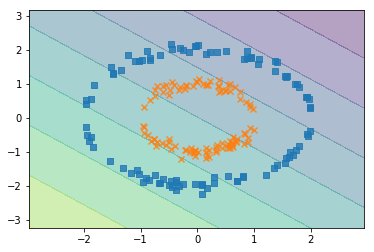

In [50]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(3000):
        feed_dict = {x_placeholder:X, y_placeholder:Y}
        sess.run(train_step,feed_dict=feed_dict)
        
    preds =  sess.run(final_output,feed_dict=feed_dict)
    print('无隐层准确率：%f' %accuracy(preds,Y))
    plot_decision_regions(X,Y,final_output)
    

In [51]:
#重置数据
#加了一层
tf.reset_default_graph()
x_placeholder = tf.placeholder(tf.float32, [None, X.shape[1]]) 
y_placeholder = tf.placeholder(tf.float32, [None, Y.shape[1]])
#隐层节点个数
i = 10
#输入层到隐层
w1 =tf.Variable(tf.random_uniform([2,i], -1, 1))
b1= tf.Variable(tf.zeros([1, 1]))
#隐层到输出层
w2 = tf.Variable(tf.random_uniform([i,1], -1, 1))
b2 = tf.Variable(tf.zeros([1, 1]))
#中间层，tahn
layer = tf.nn.tanh(tf.matmul(x_placeholder, w1) + b1)
#输出层
y = tf.sigmoid(tf.matmul(layer, w2) + b2)
cost = tf.reduce_mean(
    tf.nn.sigmoid_cross_entropy_with_logits(logits=y, labels=y_placeholder)
)

单隐层准确率:0.975000


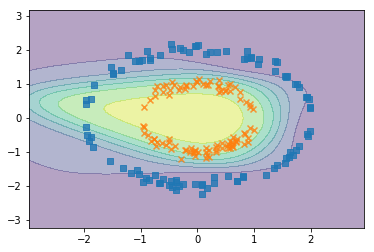

In [52]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(25000):
        feed_dict = {x_placeholder:X, y_placeholder:Y}
        sess.run(train_step,feed_dict=feed_dict)

    preds = sess.run(y,feed_dict=feed_dict)
    print('单隐层准确率:%f'%accuracy(preds,Y))
    plot_decision_regions(X,Y,y)

#### Adam Algorithmus:
an algorithm for first-order gradient-based optimization of stochastic objective functions, based on adaptive estimates of lower-order moments. 

单隐层准确率:1.000000


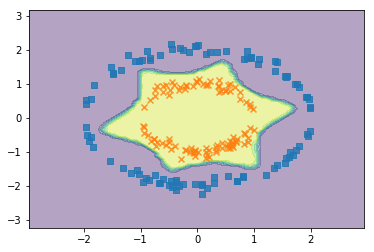

In [23]:
train_step = tf.train.AdamOptimizer(0.01).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(25000):
        feed_dict = {x_placeholder:X, y_placeholder:Y}
        sess.run(train_step,feed_dict=feed_dict)

    preds = sess.run(y,feed_dict=feed_dict)
    print('单隐层准确率:%f'%accuracy(preds,Y))
    plot_decision_regions(X,Y,y)

### 还可改善的点
1. [把数据分成train，validation，test三部分](https://github.com/scottming/DeepLearning101/blob/scott/ch3/code/3w-asgn.ipynb)
2. [用subplot把不同迭代次数的图画出来](https://github.com/ruibofeng/DeepLearning101/blob/master/ch3/project/assignment_ch3.ipynb)
3. [3D决策面](https://github.com/miandai/DeepLearning101/blob/master/ch3/project/ch3_3_neuralnet.ipynb)